# Movie Recommender System - Content Based Filtering

* Nama : Andi Engku Putribuana
* Email : andiengku1922@gmail.com
* ID Dicoding: putribuana

## Import Library

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

ls: cannot access 'kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
#!/bin/bash
!kaggle datasets download narayan63/netflix-popular-movies-dataset

Dataset URL: https://www.kaggle.com/datasets/narayan63/netflix-popular-movies-dataset
License(s): CC0-1.0
  0% 0.00/1.17M [00:00<?, ?B/s]
100% 1.17M/1.17M [00:00<00:00, 42.7MB/s]


In [4]:
import zipfile

zip_path = '/content/netflix-popular-movies-dataset.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('netflix/')
zip_ref.close()

In [5]:
netflix = '/content/netflix/n_movies.csv'

df = pd.read_csv(netflix)
df.head(5)

,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"Action, Comedy, Drama",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"Crime, Drama",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"Drama, Horror, Mystery",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"Animation, Action, Adventure",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"


## Check Dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9957 entries, 0 to 9956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        9957 non-null   object 
 1   year         9430 non-null   object 
 2   certificate  6504 non-null   object 
 3   duration     7921 non-null   object 
 4   genre        9884 non-null   object 
 5   rating       8784 non-null   float64
 6   description  9957 non-null   object 
 7   stars        9957 non-null   object 
 8   votes        8784 non-null   object 
dtypes: float64(1), object(8)
memory usage: 700.2+ KB


In [7]:
df.isnull().sum()

,0
title,0
year,527
certificate,3453
duration,2036
genre,73
rating,1173
description,0
stars,0
votes,1173


### Mengatasi Missing Value

Karena terdapat banyak missing value pada data yaitu pada kolom `year` sebanyak 527, kolom `certificate` sebanyak 3453, kolom `duration` sebanyak 2036, kolom `genre` = 73, kolom `rating` 1173 dan kolom `votes`= 1173, maka dari itu kita akan membersihkannya

In [8]:
df.dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5754 entries, 0 to 9956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        5754 non-null   object 
 1   year         5754 non-null   object 
 2   certificate  5754 non-null   object 
 3   duration     5754 non-null   object 
 4   genre        5754 non-null   object 
 5   rating       5754 non-null   float64
 6   description  5754 non-null   object 
 7   stars        5754 non-null   object 
 8   votes        5754 non-null   object 
dtypes: float64(1), object(8)
memory usage: 449.5+ KB


sekarang, data yg kita miliki berjumlah 5754 baris

## Data Preprocessing

### Cek nilai unik setiap kolom

In [10]:
df.title.unique()

array(['Cobra Kai', 'The Crown', 'Better Call Saul', ...,
       'The Drew Barrymore Show', 'Dash & Lily',
       'Winning Time: The Rise of the Lakers Dynasty'], dtype=object)

In [11]:
df.year.unique()

array(['(2018– )', '(2016– )', '(2015–2022)', '(2022)', '(2022– )',
       '(2013– )', '(2008–2013)', '(II) (2022)', '(2010–2022)',
       '(2013–2022)', '(2001)', '(2005– )', '(2005–2020)', '(2011– )',
       '(2003– )', '(1994–2004)', '(2011–2021)', '(2009–2020)',
       '(2017–2022)', '(2011–2019)', '(2013–2020)', '(2019– )',
       '(1989–1998)', '(2016–2021)', '(2019–2023)', '(2013–2021)',
       '(2021– )', '(2000–2007)', '(2014– )', '(2015– )', '(2020–2023)',
       '(2013–2023)', '(2020–2022)', '(2017–2020)', '(2003)',
       '(2009–2017)', '(1999– )', '(2016–2022)', '(2005–2014)',
       '(2009–2015)', '(2015–2018)', '(2010– )', '(2015–2020)', '(2021)',
       '(2002)', '(2000)', '(2012)', '(2017– )', '(2008–2014)',
       '(2007–2015)', '(2014–2023)', '(2009– )', '(2015–2019)',
       '(1998–2006)', '(2020)', '(1997)', '(2020– )', '(2010–2017)',
       '(2006–2013)', '(2011–2018)', '(2019)', '(2010–2015)',
       '(2001–2017)', '(1987–1994)', '(2014–2020)', '(2017–2021)',
   

Pada kolom year, terlihat data tanggal yang bervariasi dengan beberapa pola diantarany :

- (YYYY): Hanya tahun.
- (YYYY– ): Tahun mulai hingga sekarang.
- (YYYY–YYYY): Tahun mulai hingga tahun berakhir.
- (II) (YYYY): Tahun dengan penanda tambahan (II).
- (YYYY–2022): Tahun mulai hingga 2022

maka dari itu, kita akan melakukan perbaikan

In [12]:
def clean_year(year_str):
    """Membersihkan dan mengekstrak tahun dari string."""
    # Menghapus tanda kurung dan spasi ekstra
    year_str = year_str.strip('()').strip()

    # Pola untuk mencocokkan tahun
    match = re.search(r'(\d{4})', year_str)

    if match:
        return match.group(1)  # Mengembalikan tahun jika ditemukan
    else:
        return None  # Mengembalikan None jika tidak ditemukan

# Terapkan fungsi clean_year ke kolom 'year'
df['year'] = df['year'].apply(clean_year)

# Ubah kolom 'year' menjadi tipe data datetime
df['year'] = pd.to_datetime(df['year'], format='%Y', errors='coerce')

Cek Hasil perbaikan kolom `year`

In [13]:
df.year.unique()

<DatetimeArray>
['2018-01-01 00:00:00', '2016-01-01 00:00:00', '2015-01-01 00:00:00',
 '2022-01-01 00:00:00', '2013-01-01 00:00:00', '2008-01-01 00:00:00',
 '2010-01-01 00:00:00', '2001-01-01 00:00:00', '2005-01-01 00:00:00',
 '2011-01-01 00:00:00', '2003-01-01 00:00:00', '1994-01-01 00:00:00',
 '2009-01-01 00:00:00', '2017-01-01 00:00:00', '2019-01-01 00:00:00',
 '1989-01-01 00:00:00', '2021-01-01 00:00:00', '2000-01-01 00:00:00',
 '2014-01-01 00:00:00', '2020-01-01 00:00:00', '1999-01-01 00:00:00',
 '2002-01-01 00:00:00', '2012-01-01 00:00:00', '2007-01-01 00:00:00',
 '1998-01-01 00:00:00', '1997-01-01 00:00:00', '2006-01-01 00:00:00',
 '1987-01-01 00:00:00', '1993-01-01 00:00:00', '1975-01-01 00:00:00',
 '1995-01-01 00:00:00', '1984-01-01 00:00:00', '2004-01-01 00:00:00',
 '1966-01-01 00:00:00', '1976-01-01 00:00:00', '1982-01-01 00:00:00',
 '1990-01-01 00:00:00', '1978-01-01 00:00:00', '1968-01-01 00:00:00',
 '1980-01-01 00:00:00', '1971-01-01 00:00:00', '1991-01-01 00:00:00',
 '19

In [14]:
df.certificate.unique()

array(['TV-14', 'TV-MA', 'NC-17', 'R', 'PG-13', 'TV-PG', 'PG',
       'Not Rated', 'TV-Y7-FV', 'Approved', 'G', 'Unrated', 'TV-G',
       'TV-Y7', 'MA-17', 'TV-Y', 'Passed', '12', 'M'], dtype=object)

In [15]:
df.duration.unique()

array(['30 min', '58 min', '46 min', '356 min', '24 min', '45 min',
       '23 min', '49 min', '166 min', '51 min', '89 min', '44 min',
       '139 min', '118 min', '110 min', '60 min', '178 min', '41 min',
       '50 min', '22 min', '326 min', '122 min', '101 min', '43 min',
       '42 min', '114 min', '55 min', '48 min', '113 min', '201 min',
       '53 min', '54 min', '7 min', '104 min', '187 min', '179 min',
       '147 min', '102 min', '169 min', '47 min', '534 min', '194 min',
       '88 min', '75 min', '25 min', '15 min', '70 min', '59 min',
       '127 min', '124 min', '106 min', '97 min', '52 min', '65 min',
       '135 min', '572 min', '112 min', '138 min', '155 min', '450 min',
       '121 min', '117 min', '111 min', '151 min', '129 min', '149 min',
       '98 min', '108 min', '116 min', '94 min', '40 min', '268 min',
       '132 min', '115 min', '128 min', '80 min', '56 min', '99 min',
       '545 min', '140 min', '96 min', '90 min', '125 min', '11 min',
       '270 min', '

pada kolom durasi juga terlihat pola yang tidak rapi dan tipe datanya masih string, maka dari itu kita akan lakukan perbaikan

In [16]:
import re

def clean_duration(duration_str):
    """Membersihkan dan mengekstrak durasi dalam menit dari string."""
    match = re.search(r'(\d+)\s*min', duration_str)
    if match:
        return int(match.group(1))
    else:
        return None  # Mengembalikan None jika tidak ditemukan

# Terapkan fungsi clean_duration ke kolom 'duration'
df['duration'] = df['duration'].apply(clean_duration)

In [17]:
df['duration'] = pd.to_timedelta(df['duration'], unit='m')

In [18]:
df.duration.unique()

<TimedeltaArray>
['0 days 00:30:00', '0 days 00:58:00', '0 days 00:46:00', '0 days 05:56:00',
 '0 days 00:24:00', '0 days 00:45:00', '0 days 00:23:00', '0 days 00:49:00',
 '0 days 02:46:00', '0 days 00:51:00',
 ...
 '0 days 00:02:00', '0 days 05:03:00', '0 days 04:05:00', '0 days 00:14:00',
 '0 days 03:04:00', '0 days 02:26:00', '0 days 06:58:00', '0 days 02:33:00',
 '0 days 03:06:00', '0 days 02:45:00']
Length: 285, dtype: timedelta64[ns]

In [19]:
df.genre.value_counts()

,count
genre,
"Animation, Action, Adventure",450
Comedy,426
Drama,221
Documentary,204
"Crime, Drama, Mystery",184
...,...
"Film-Noir, Thriller",1
"Documentary, Animation, Sci-Fi",1
"Comedy, History",1


### Ekstraksi List Genre

In [20]:
print(df['genre'])

0              Action, Comedy, Drama
1          Biography, Drama, History
2                       Crime, Drama
3             Drama, Horror, Mystery
4       Animation, Action, Adventure
                    ...             
9952        Action, Adventure, Drama
9953         Drama, Horror, Thriller
9954       Biography, Drama, History
9955          Drama, Fantasy, Horror
9956          Drama, Horror, Mystery
Name: genre, Length: 5754, dtype: object


In [21]:
from collections import Counter
# Fungsi untuk mengekstraksi dan merapikan kolom genre
def extract_genre(genre_list):
    if pd.isna(genre_list):
        return []
    # Remove unwanted characters and split
    genres = genre_list.strip('[]').replace('"', '').replace("'", '').split(',')
    return [genre.strip() for genre in genres]  # Clean up each genre

# Apply the function to the genre column
df['genre'] = df['genre'].apply(extract_genre)

# Explode the data to separate genres into individual rows
df_exploded = df.explode('genre')

# Calculate the frequency of each genre using Counter
genre_counter = Counter(df_exploded['genre'])

# Create a DataFrame from the Counter results
genre_counts_df = pd.DataFrame(genre_counter.items(), columns=['genre', 'frequency'])

# Display the DataFrame with genre frequencies
print(genre_counts_df)

          genre  frequency
0        Action       1393
1        Comedy       1835
2         Drama       2647
3     Biography        248
4       History        240
5         Crime       1051
6        Horror        365
7       Mystery        538
8     Animation       1003
9     Adventure       1164
10      Fantasy        340
11     Thriller        579
12      Romance        540
13        Sport        102
14       Sci-Fi        205
15        Short        129
16          War         44
17        Music        134
18       Family        255
19  Documentary        692
20      Musical         36
21      Western         25
22   Reality-TV        241
23    Game-Show         51
24    Talk-Show         27
25    Film-Noir         12
26         News         13


In [22]:
df.rating.unique()

array([8.5, 8.7, 8.9, 5.9, 8.6, 7.8, 9.2, 9.5, 6.3, 6.2, 4.7, 8.1, 6.4,
       6.1, 5.8, 8.8, 7.6, 8.4, 8. , 7.4, 6.5, 5. , 8.2, 7.9, 6.8, 5.3,
       9. , 7.1, 7.3, 7.7, 8.3, 7.5, 6.6, 3.3, 9.1, 6.7, 6.9, 5.4, 2.7,
       7.2, 2.6, 9.3, 5.7, 7. , 5.5, 4.9, 5.2, 4. , 4.5, 5.6, 4.8, 4.4,
       5.1, 6. , 3.9, 4.1, 4.2, 2.8, 3.5, 3.8, 4.6, 3.6, 3.7, 4.3, 2.9,
       3.2, 3.4, 3.1, 2.3, 2.5, 2.1, 3. , 2.2, 2. , 1.7, 9.6, 9.4, 9.9])

In [23]:
df.description.unique()

array(['Decades after their 1984 All Valley Karate Tournament bout, a middle-aged Daniel LaRusso and Johnny Lawrence find themselves martial-arts rivals again.',
       "Follows the political rivalries and romance of Queen Elizabeth II's reign and the events that shaped the second half of the twentieth century.",
       'The trials and tribulations of criminal lawyer Jimmy McGill before his fateful run-in with Walter White and Jesse Pinkman.',
       ...,
       'Life and death spin savagely out of control. Familiar faces scramble to survive the brutality, and wrenching betrayal lurks around every corner.',
       "Johnny & Dukey see a preview for a new Speed McCool comedy.You're supposed to be 18 and willing to serve in the military to play a new on-line game - but that won't stop Johnny.",
       "The U.S.S. Discovery crew travel to Book's home planet to help rescue it from Osyraa, the formidable leader of the Emerald Chain; Stamets and Adira continue their search for valuable inform

In [24]:
df.stars.unique()

array(["['Ralph Macchio, ', 'William Zabka, ', 'Courtney Henggeler, ', 'Xolo Maridueña']",
       "['Claire Foy, ', 'Olivia Colman, ', 'Imelda Staunton, ', 'Matt Smith']",
       "['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan Banks, ', 'Patrick Fabian']",
       ...,
       "['Michelle Buteau, ', 'Karyn Blanco, ', 'Sammie Cimarelli, ', 'Antonio DePina']",
       "['Mira Nair', '| ', '    Stars:', 'Tanya Maniktala, ', 'Danesh Razvi, ', 'Boloram Das, ', 'Mahira Kakkar']",
       "['John Hyams', '| ', '    Stars:', 'Jaime King, ', 'Justin Chu Cary, ', 'Christine Lee, ', 'Zoe Marlett']"],
      dtype=object)

In [25]:
df.votes.unique()

array(['177,031', '199,885', '501,384', ..., '199,898', '439,601',
       '9,786'], dtype=object)

mengganti tipe data `votes` ke numerik

In [26]:
df['votes'] = df['votes'].str.replace(',', '').astype(int)

### Transformasi Variabel Numerik

<Axes: xlabel='rating', ylabel='Count'>

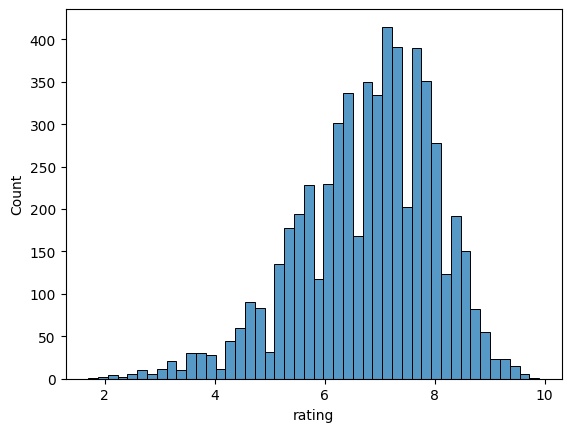

In [27]:
sns.histplot(df['rating'])

Pada visualisasi diatas, dapat dilihat bahwa pada kolom rating film didominasi oleh scala rating 6 sampai 8.

<Axes: xlabel='votes', ylabel='Count'>

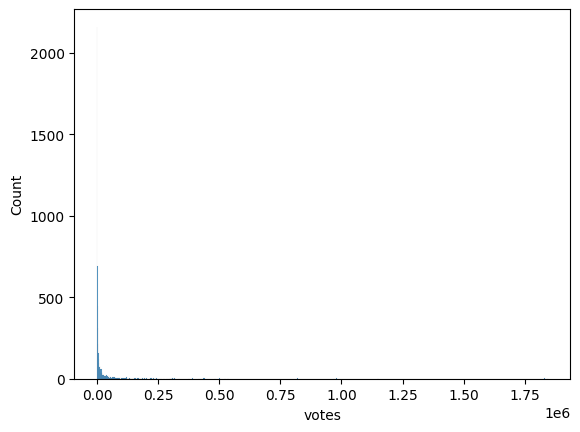

In [28]:
sns.histplot(df['votes'])

## EDA

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5754 entries, 0 to 9956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   title        5754 non-null   object         
 1   year         5754 non-null   datetime64[ns] 
 2   certificate  5754 non-null   object         
 3   duration     5754 non-null   timedelta64[ns]
 4   genre        5754 non-null   object         
 5   rating       5754 non-null   float64        
 6   description  5754 non-null   object         
 7   stars        5754 non-null   object         
 8   votes        5754 non-null   int64          
dtypes: datetime64[ns](1), float64(1), int64(1), object(5), timedelta64[ns](1)
memory usage: 449.5+ KB


### Kagorikal Fitur

In [30]:
objects = ['title','certificate', 'genre', 'description', 'stars']

category_df = df[objects]

In [31]:
category_df.head()

,title,certificate,genre,description,stars
0,Cobra Kai,TV-14,"[Action, Comedy, Drama]",Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn..."
1,The Crown,TV-MA,"[Biography, Drama, History]",Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St..."
2,Better Call Saul,TV-MA,"[Crime, Drama]",The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan..."
3,Devil in Ohio,TV-MA,"[Drama, Horror, Mystery]",When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo..."
4,Cyberpunk: Edgerunners,TV-MA,"[Animation, Action, Adventure]",A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ..."


In [32]:
category_df.describe()

,title,certificate,genre,description,stars
count,5754,5754,5754,5754,5754
unique,4413,19,455,5700,5186
top,Top Gear,TV-MA,"[Animation, Action, Adventure]",Add a Plot,[]
freq,84,2197,450,17,28


In [33]:
objects = ['genre']
category_df[objects].describe()

,genre
count,5754
unique,455
top,"[Animation, Action, Adventure]"
freq,450


### Numerik (float) Fitur

In [34]:
#For Numerical Column
numerical = [col for col in df.columns if df[col].dtype in ['int', 'float64']]

for col in numerical:
    print(f'\nDescriptive statistics for {col}:')
    print(f'Mean: {df[col].mean()}')
    print(f'Median: {df[col].median()}')
    print(f'Mode: {df[col].mode().iloc[0]}')
    print(f'Standard Deviation: {df[col].std()}')
    print(f'Min: {df[col].min()}')
    print(f'Max: {df[col].max()}')
    print(f'25th Percentile: {df[col].quantile(0.25)}')
    print(f'50th Percentile: {df[col].quantile(0.50)}')
    print(f'75th Percentile: {df[col].quantile(0.75)}')


Descriptive statistics for rating:
Mean: 6.792822384428223
Median: 6.9
Mode: 7.4
Standard Deviation: 1.2262422311555317
Min: 1.7
Max: 9.9
25th Percentile: 6.1
50th Percentile: 6.9
75th Percentile: 7.7

Descriptive statistics for votes:
Mean: 29134.425269377825
Median: 2600.0
Mode: 130
Standard Deviation: 106940.38152120878
Min: 8
Max: 1844075
25th Percentile: 617.25
50th Percentile: 2600.0
75th Percentile: 11880.25


In [35]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

numeric = ['rating']

desc = df[numeric].describe()
desc.loc['kurtosis'] = df[numeric].kurt()
desc.loc['skewness'] = df[numeric].skew()
desc.loc['variance'] = df[numeric].var()
desc.round(2)

,rating
count,5754.00
mean,6.79
std,1.23
min,1.70
25%,6.10
50%,6.90
75%,7.70
max,9.90
kurtosis,0.47
skewness,-0.64


### Analisis Data

#### Bagaimana distribusi film berdasarkan tahun rilis?

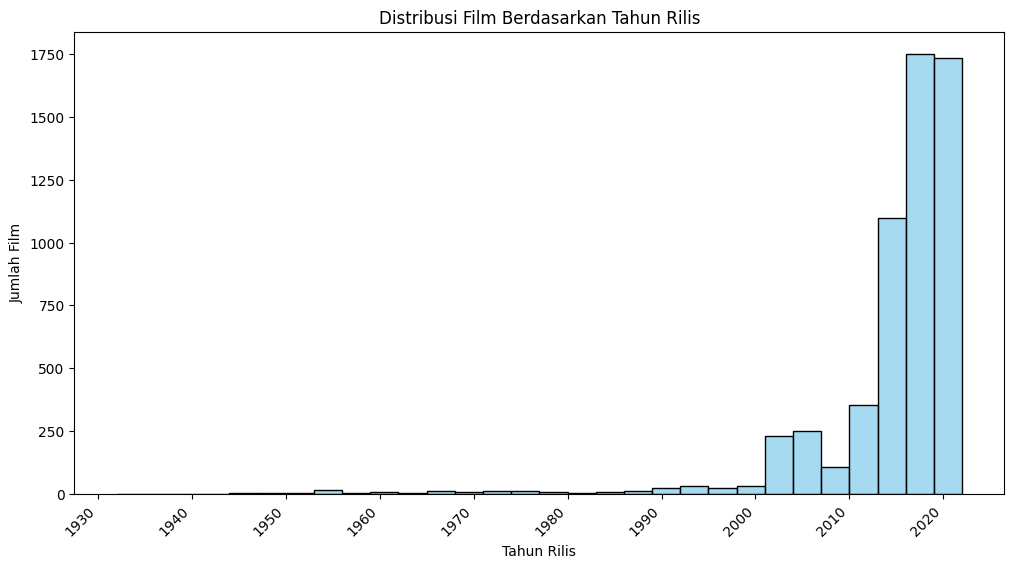

In [36]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='year', bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Film Berdasarkan Tahun Rilis')
plt.xlabel('Tahun Rilis')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45, ha='right')
plt.show()

Distribusi film berdasarkan tahun rilis didominasi sepanjang tahun 2018 hingga 2020, berbanding terbalik sepanjang tahun 1930 hingga tahun 2000, dimana film yang dirilis hanya sedikit.

#### Bagaimana tren peningkatan/penurunan jumlah film yang dirilis setiap tahunnya?

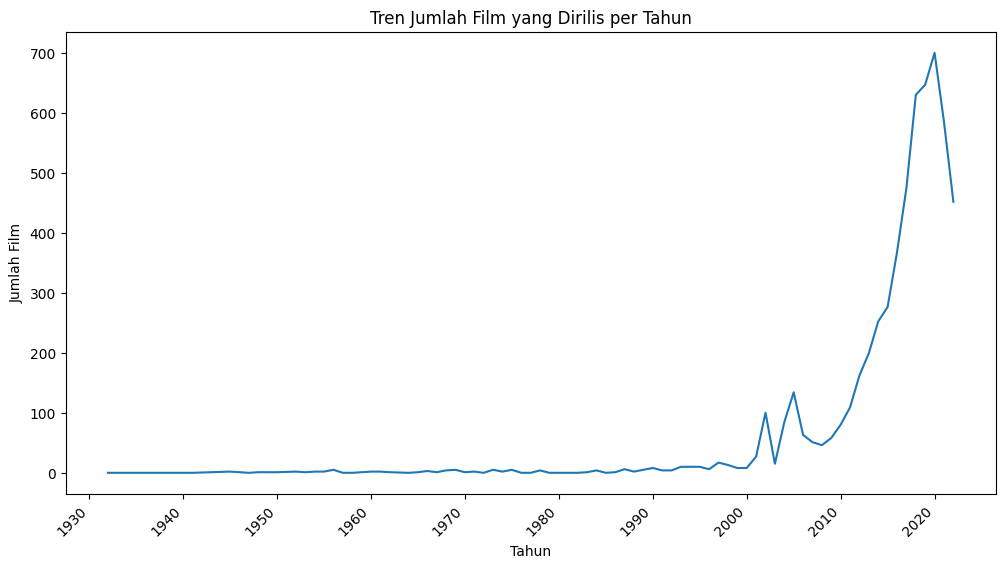

In [37]:
year_counts = df.groupby('year')['title'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=year_counts, x='year', y='title')
plt.title('Tren Jumlah Film yang Dirilis per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45, ha='right')
plt.show()

Dari visualisasi diatas, dapat dilihat bahwa terjadi peningkatan jumlah film yang di liris setiap tahunnya terutama di tahun 2020, walaupun terjadi fluktuasi setelah tahun 2020, namun pada visualisasi menggambarkan adanya peningkatan

#### Film apa saja dengan rating tertinggi tiap tahunnya?

In [38]:
highest_rated_per_year = df.loc[df.groupby('year')['rating'].idxmax()]
print(highest_rated_per_year[['title', 'year', 'rating']])

                         title       year  rating
1445                  Scarface 1932-01-01    7.70
1119                     Dumbo 1941-01-01    7.20
4072  Nazi Concentration Camps 1945-01-01    8.30
2257              The Stranger 1946-01-01    7.30
3274                     Lured 1947-01-01    7.00
...                        ...        ...     ...
8618                 Cobra Kai 2018-01-01    9.40
1406                Our Planet 2019-01-01    9.30
9229    Julie and the Phantoms 2020-01-01    9.20
76                      Arcane 2021-01-01    9.00
9000               The Sandman 2022-01-01    9.20

[76 rows x 3 columns]


Film dengan rating tertinggi adalah film dengan judul Cobra Kai dengan rating 9.40, Our Planet 9.30, Julie and the Phantoms 9.20, Arcane 9.00, dan The sandman 9.20

#### Film apa saja dengan votes terbanyak setiap tahunnya?

In [39]:
most_voted_per_year = df.loc[df.groupby('year')['votes'].idxmax()]
print(most_voted_per_year[['title', 'year', 'votes']])

                          title       year   votes
1445                   Scarface 1932-01-01   28107
1119                      Dumbo 1941-01-01  131896
4627           Along Came Jones 1945-01-01    2163
2257               The Stranger 1946-01-01   26705
3274                      Lured 1947-01-01    3811
...                         ...        ...     ...
340                       Venom 2018-01-01  478585
384   Spider-Man: Far from Home 2019-01-01  482390
126          The Queen's Gambit 2020-01-01  432644
148               Don't Look Up 2021-01-01  525424
229            The Adam Project 2022-01-01  193255

[76 rows x 3 columns]


Disisi lain, film dengan vote terbanyak setiap tahunnya adalah film dengan judul Don't Look Up 525424, Venom sebanyak 478585, Spider-Man: Far from Home, The Queen's Gambit, dan The Adam Project.

#### Bagaimana distribusi rating film?

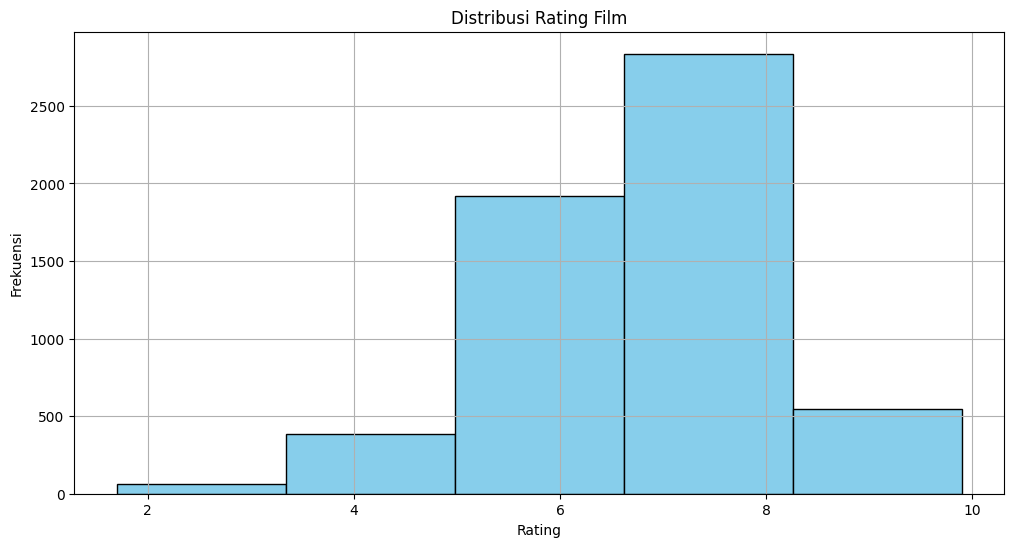

In [40]:
plt.figure(figsize=(12, 6))
plt.hist(df['rating'], bins=5, color='skyblue', edgecolor='black')
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

Dari visualisasi diatas, dapat dilihat bahwa distribusi rating film didominasi rating 7 sampai 8, disusul oleh rating 5 sampai 6, dan untuk rating 2 menduduki peingkat terendah.

#### Genre apa yang paling disukai?

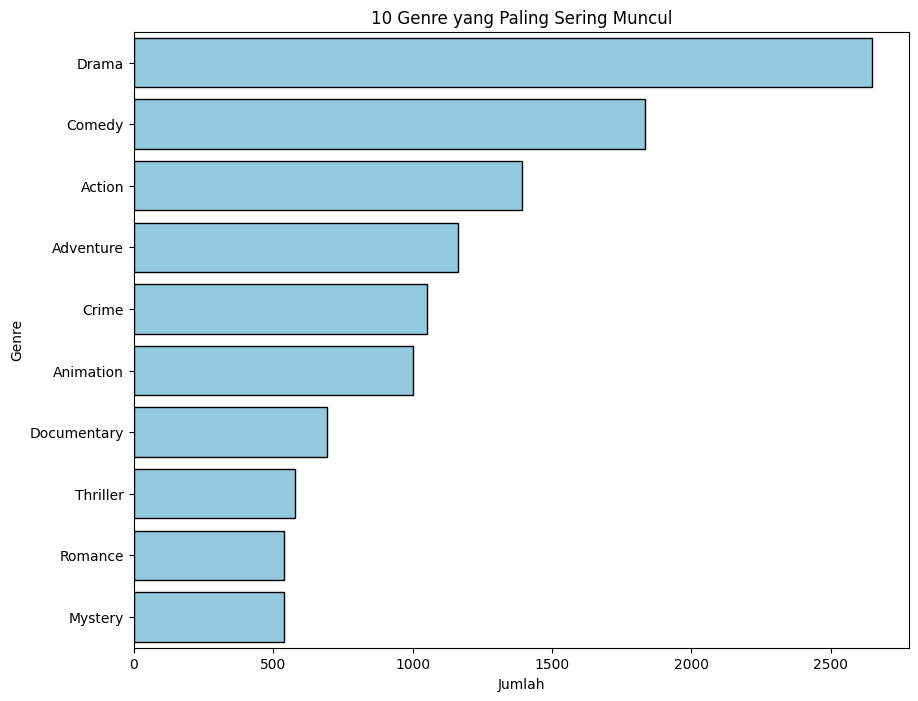

In [41]:
# Calculate the frequency of each genre using Counter
genre_counter = Counter(df_exploded['genre'])

# Create a DataFrame from the Counter results
genre_counts_df = pd.DataFrame(genre_counter.items(), columns=['genre', 'frequency'])

# Mengambil 10 genre teratas
top_10_genres = genre_counts_df.sort_values(by=['frequency'], ascending=False).head(10)

# Plot horizontal barplot untuk 10 genre teratas
plt.figure(figsize=(10, 8))
sns.barplot(data=top_10_genres, y='genre', x='frequency', orient='h', color='skyblue', edgecolor='black')
plt.title('10 Genre yang Paling Sering Muncul')
plt.xlabel('Jumlah')
plt.ylabel('Genre')
plt.show()

Pada visualisasi diatas, dapat dilihat bahwa genre terfavorit dimenangkan oleh film bergenre "Drama", kemudian disusul oleh film bergenre "COmedy", "Action", "Adventure" dll.

## Data Preparation

#### Melihat nilai unik pada kolom genre

In [42]:
df['genre'] = df['genre'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

unique_genres = df['genre'].unique()
print(unique_genres)

['Action, Comedy, Drama' 'Biography, Drama, History' 'Crime, Drama'
 'Drama, Horror, Mystery' 'Animation, Action, Adventure'
 'Drama, Fantasy, Horror' 'Animation, Adventure, Comedy'
 'Crime, Drama, Thriller' 'Action, Adventure, Drama'
 'Biography, Drama, Mystery' 'Action, Crime, Drama'
 'Drama, Horror, Thriller' 'Crime, Drama, Mystery' 'Comedy' 'Thriller'
 'Drama, Romance, Sport' 'Drama, Romance' 'Drama, Horror, Sci-Fi'
 'Action, Biography, Crime' 'Comedy, Romance' 'Comedy, Drama'
 'Comedy, Drama, Romance' 'Drama, Mystery, Thriller' 'Action, Thriller'
 'Crime, Drama, Fantasy' 'Action, Adventure, Comedy'
 'Action, Drama, History' 'Drama' 'Drama, Mystery, Sci-Fi' 'Comedy, Crime'
 'Action, Drama, Mystery' 'Drama, Fantasy, Romance'
 'Action, Comedy, Fantasy' 'Animation, Comedy' 'Animation, Short, Action'
 'Action, Drama' 'Action, Drama, War' 'Crime, Drama, Horror'
 'Adventure, Fantasy' 'Animation, Action, Comedy'
 'Biography, Crime, Drama' 'Crime, Drama, Romance' 'Comedy, Drama, Music'
 'D

#### Mengecek kategori genre "drama"

In [43]:
df[df['genre'] == 'Drama']

,title,year,certificate,duration,genre,rating,description,stars,votes
41,Partner Track,2022-01-01,TV-MA,0 days 01:00:00,Drama,6.80,"Centers on Ingrid Yun, an idealistic young law...","['Arden Cho, ', 'Alexandra Turshen, ', 'Bradle...",3840
63,Diario de un Gigoló,2022-01-01,TV-MA,0 days 00:50:00,Drama,6.30,A gigolo's life begins to unravel when he beco...,"['Jesús Castro, ', 'Victoria White, ', 'Fabiol...",538
86,Mad Men,2007-01-01,TV-14,0 days 00:47:00,Drama,8.70,A drama about one of New York's most prestigio...,"['Jon Hamm, ', 'Elisabeth Moss, ', 'Vincent Ka...",237030
104,The Good Doctor,2017-01-01,TV-14,0 days 00:41:00,Drama,8.10,"Shaun Murphy, a young surgeon with autism and ...","['Freddie Highmore, ', 'Hill Harper, ', 'Richa...",92641
106,Extraordinary Attorney Woo,2022-01-01,TV-14,0 days 01:15:00,Drama,8.90,About an autistic 27-year-old lawyer. Due to h...,"['Park Eun-bin, ', 'Kang Tae-oh, ', 'Kang Ki-y...",9538
...,...,...,...,...,...,...,...,...,...
9644,Inventing Anna,2022-01-01,TV-MA,0 days 01:23:00,Drama,6.80,Anna obsesses over her trial style as Vivian c...,"['Ellen Kuras', '| ', ' Stars:', 'Anna Chlu...",916
9645,Dynasty,2017-01-01,TV-PG,0 days 00:42:00,Drama,7.80,Blake celebrates what could be his last Thanks...,"['Geoffrey Wing Shotz', '| ', ' Stars:', 'E...",424
9728,Baby,2018-01-01,TV-MA,0 days 00:51:00,Drama,7.30,After an acquaintance is caught in a police ra...,"['Andrea De Sica', '| ', ' Stars:', 'Benede...",119
9747,Dynasty,2017-01-01,TV-14,0 days 00:42:00,Drama,8.30,"Blake's trial begins, and every Carrington and...","['Melanie Mayron', '| ', ' Stars:', 'Elizab...",448


#### Konversi data dengan  Tolist

In [44]:
# Convert a Pandas Series to a list:
title_list = df['title'].tolist()

# Convert a specific column with multiple values (like 'genre') to a list of lists:
genre_lists = df['genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else x).tolist()

stars_list = df['rating'].tolist()

array = np.array([1, 2, 3])
list_from_array = array.tolist()

print(len(title_list))
print(len(genre_lists))
print(len(stars_list))

5754
5754
5754


#### Membuat dictionary pada data

In [45]:
movie_dict = {}
for i in range(len(title_list)):
    movie_id = i
    movie_dict[movie_id] = {
        'title': title_list[i],
        'genre': genre_lists[i],
        'rating': stars_list[i]
    }

movie_dict

{0: {'title': 'Cobra Kai',
  'genre': ['Action', 'Comedy', 'Drama'],
  'rating': 8.5},
 1: {'title': 'The Crown',
  'genre': ['Biography', 'Drama', 'History'],
  'rating': 8.7},
 2: {'title': 'Better Call Saul', 'genre': ['Crime', 'Drama'], 'rating': 8.9},
 3: {'title': 'Devil in Ohio',
  'genre': ['Drama', 'Horror', 'Mystery'],
  'rating': 5.9},
 4: {'title': 'Cyberpunk: Edgerunners',
  'genre': ['Animation', 'Action', 'Adventure'],
  'rating': 8.6},
 5: {'title': 'The Sandman',
  'genre': ['Drama', 'Fantasy', 'Horror'],
  'rating': 7.8},
 6: {'title': 'Rick and Morty',
  'genre': ['Animation', 'Adventure', 'Comedy'],
  'rating': 9.2},
 7: {'title': 'Breaking Bad',
  'genre': ['Crime', 'Drama', 'Thriller'],
  'rating': 9.5},
 8: {'title': 'The Imperfects',
  'genre': ['Action', 'Adventure', 'Drama'],
  'rating': 6.3},
 9: {'title': 'Blonde',
  'genre': ['Biography', 'Drama', 'Mystery'],
  'rating': 6.2},
 10: {'title': 'Stranger Things',
  'genre': ['Drama', 'Fantasy', 'Horror'],
  'r

In [46]:
movie_df = pd.DataFrame.from_dict(movie_dict, orient='index')
movie_df.head()

,title,genre,rating
0,Cobra Kai,"[Action, Comedy, Drama]",8.50
1,The Crown,"[Biography, Drama, History]",8.70
2,Better Call Saul,"[Crime, Drama]",8.90
3,Devil in Ohio,"[Drama, Horror, Mystery]",5.90
4,Cyberpunk: Edgerunners,"[Animation, Action, Adventure]",8.60


In [47]:
data = movie_df
data.sample(5)

,title,genre,rating
5335,The House of Flowers,"[Comedy, Drama]",6.50
3062,Queen Sono,"[Action, Crime, Drama]",6.00
5218,She-Ra and the Princesses of Power,"[Animation, Action, Adventure]",8.20
2811,Rocky Handsome,"[Action, Crime, Drama]",6.80
1214,In the Name of the King: A Dungeon Siege Tale,"[Action, Adventure, Fantasy]",3.80


## TF-IDF

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Ubah list genre menjadi string
data['genre_str'] = data['genre'].apply(lambda x: ' '.join(x))

# Melakukan perhitungan idf pada data genre yang sudah diubah menjadi string
tf.fit(data['genre_str'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'fi', 'film', 'game',
       'history', 'horror', 'music', 'musical', 'mystery', 'news', 'noir',
       'reality', 'romance', 'sci', 'short', 'show', 'sport', 'talk',
       'thriller', 'tv', 'war', 'western'], dtype=object)

In [49]:
tfidf_matrix = tf.fit_transform(data['genre_str'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(5754, 31)

In [50]:
tfidf_matrix.todense()

matrix([[0.65584709, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [51]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.title
).sample(5, axis=1).sample(10, axis=0)

,show,biography,sport,music,war
title,,,,,
You Animal!,0.00,0.00,0.00,0.00,0.00
Legally High,0.00,0.00,0.00,0.00,0.00
Carmel: Who Killed Maria Marta?,0.00,0.00,0.00,0.00,0.00
Inside the World's Toughest Prisons,0.00,0.00,0.00,0.00,0.00
American Experience,0.00,0.62,0.00,0.00,0.00
Baki Hanma,0.00,0.00,0.00,0.00,0.00
Karakai Jouzu no Takagi-san,0.00,0.00,0.00,0.00,0.00
Tom Segura: Disgraceful,0.00,0.00,0.00,0.00,0.00
Bleach,0.00,0.00,0.00,0.00,0.00


## Cosine Similiarity

In [52]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.13936107, 0.26484661, ..., 0.13936107, 0.15153875,
        0.16002668],
       [0.13936107, 1.        , 0.15899709, ..., 1.        , 0.09097425,
        0.09606986],
       [0.26484661, 0.15899709, 1.        , ..., 0.15899709, 0.17289061,
        0.18257449],
       ...,
       [0.13936107, 1.        , 0.15899709, ..., 1.        , 0.09097425,
        0.09606986],
       [0.15153875, 0.09097425, 0.17289061, ..., 0.09097425, 1.        ,
        0.5713586 ],
       [0.16002668, 0.09606986, 0.18257449, ..., 0.09606986, 0.5713586 ,
        1.        ]])

In [63]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap judul
cosine_sim_df.sample(10, axis=1).sample(3, axis=0)

Shape: (5754, 5754)


title,The Disappearance of Haruhi Suzumiya,Grumpy Christmas,Rebellion,Lift Me Up,The 100,Johnny Test,Love in the Villa,Any Day Now,Virgin River,How It Ends
title,,,,,,,,,,
Shaun the Sheep: The Flight Before Christmas,0.86,0.40,0.00,0.76,0.00,0.31,0.21,0.00,0.00,0.00
The Movies That Made Us,0.49,0.00,0.35,0.62,0.00,0.00,0.00,0.00,0.00,0.00
Jeff Dunham: Unhinged in Hollywood,0.00,1.00,0.00,0.00,0.00,0.00,0.54,0.00,0.00,0.00


## Mendapatkan Rekomendasi


In [54]:
def movie_recommendations(movie_title, similarity_data=cosine_sim_df, items=data[['title', 'genre', 'rating']], k=10):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak lengkap
    index = similarity_data.loc[:,movie_title].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang sudah dipartisi
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop movie_title agar judul yang dicari tidak direkomendasikan
    closest = closest.drop(movie_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [62]:
movie_recommendations("Legally High", k=10)

,title,genre,rating
0,League of Legends Origins,[Documentary],6.50
1,Last Breath,[Documentary],7.70
2,How to Change Your Mind,[Documentary],7.90
3,Pandemic: How to Prevent an Outbreak,[Documentary],6.40
4,Chelsea Does,[Documentary],7.30
5,The Director: An Evolution in Three Acts,[Documentary],6.20
6,Our Great National Parks,[Documentary],7.90
7,The Blue Planet,[Documentary],8.10
8,The Blue Planet,[Documentary],8.60
9,The Blue Planet,[Documentary],8.10


In [64]:
movie_recommendations("Rebellion", k=10)

,title,genre,rating
0,1898: Our Last Men in the Philippines,"[Drama, History, War]",6.50
1,War Flowers,"[Drama, History, War]",4.20
2,Macbeth,"[Drama, History, War]",6.60
3,Skyggen i mit øje,"[Drama, History, War]",7.30
4,Cadet 1947,"[Drama, History, War]",6.50
5,Naked Among Wolves,"[Drama, History, War]",7.20
6,Winter in Wartime,"[Drama, History, War]",7.00
7,Loose Change 9/11: An American Coup,"[Documentary, History, War]",7.10
8,Zeitgeist: Addendum,"[Documentary, History, War]",8.20
9,Turning Point: 9/11 and the War on Terror,"[Documentary, History, War]",8.00
